## 案例: 人脸识别

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from PIL import Image

In [2]:

from sklearn.datasets import fetch_lfw_people 
# 这儿有Bug, 不同的min_faces_per_person报错不一样, 暂且跳过
faces = fetch_lfw_people(min_faces_per_person=20)

['George W Bush' 'Gerhard Schroeder' 'Gloria Macapagal Arroyo'
 'Igor Ivanov' 'Tiger Woods']
(243, 62, 47)


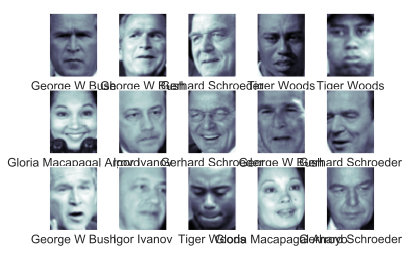

In [3]:
print(faces.target_names)
print(faces.images.shape)
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [4]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [5]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

最后，用网格搜索交叉检验来寻找最优参数组合。通过不断调整参数 C(控制边界线的硬
度)和参数 gamma(控制径向基函数核的大小)，确定最优模型:

In [6]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 5.89 s, sys: 345 ms, total: 6.24 s
Wall time: 5.56 s
{'svc__C': 50, 'svc__gamma': 0.0001}


最优参数最终落在了网格的中间位置。如果它们落在了边缘位置，我们可能就需要扩展网 格搜索范围，确保最优参数可以被搜索到。

In [7]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

将一些测试图片与预测图片进行对比:

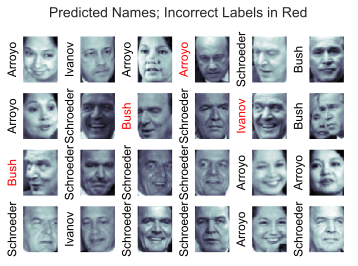

In [8]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

我们可以打印分类效果报告，它会列举每个标签的统计结果，从而对评估器 的性能有更全面的认识:

In [9]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                         precision    recall  f1-score   support

          George W Bush       0.62      1.00      0.76         8
      Gerhard Schroeder       1.00      0.83      0.91        35
Gloria Macapagal Arroyo       0.83      1.00      0.91        10
            Igor Ivanov       0.60      0.60      0.60         5
            Tiger Woods       1.00      0.67      0.80         3

            avg / total       0.89      0.85      0.86        61



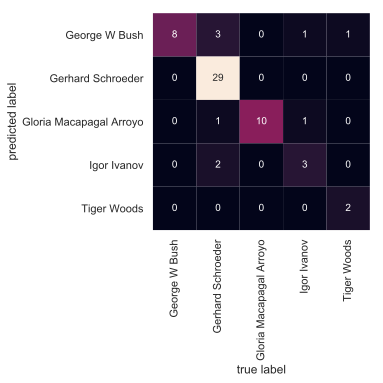

In [10]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

前面已经简单介绍了支持向量机的基本原则。支持向量机是一种强大的分类方法，主要有
四点理由。
* 模型依赖的支持向量比较少，说明它们都是非常精致的模型，消耗内存少。
* 一旦模型训练完成，预测阶段的速度非常快。
* 由于模型只受边界线附近的点的影响，因此它们对于高维数据的学习效果非常好——即
 使训练比样本维度还高的数据也没有问题，而这是其他算法难以企及的。
* 与核函数方法的配合极具通用性，能够适用不同类型的数据。

但是，SVM 模型也有一些缺点。

* 随着样本量 N 的不断增加，最差的训练时间复杂度会达到 [N3];经过高效处理后，也 只能达到 [N2]。因此，大样本学习的计算成本会非常高。
* 训练效果非常依赖于边界软化参数 C 的选择是否合理。这需要通过交叉检验自行搜索; 当数据集较大时，计算量也非常大。
* 预测结果不能直接进行概率解释。这一点可以通过内部交叉检验进行评估(具体请参见 SVC 的 probability 参数的定义)，但是评估过程的计算量也很大。
由于这些限制条件的存在，我通常只会在其他简单、快速、调优难度小的方法不能满足需 求时，才会选择支持向量机。但是，如果你的计算资源足以支撑 SVM 对数据集的训练和 交叉检验，那么用它一定能获得极好的效果。